In [1]:
def get_db_url(db, user, host, password):
    from sqlalchemy import create_engine
    url = f'mysql+pymysql://{user}:{password}@{host}/{db}'
    return create_engine(url)

In [2]:
import pandas as pd
from env import user, host, password

In [3]:
conn1 = get_db_url('telco_churn', user, host, password)

In [4]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import scipy.stats as stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

In [5]:
telco_read = pd.read_sql('describe customers;', conn1)
telco_read

,Field,Type,Null,Key,Default,Extra
0,customer_id,char(10),NO,PRI,None,
1,gender,text,YES,,None,
2,senior_citizen,bigint(20),YES,,None,
3,partner,text,YES,,None,
4,dependents,text,YES,,None,
5,tenure,bigint(20),YES,,None,
6,phone_service,text,YES,,None,
7,multiple_lines,text,YES,,None,
8,internet_service_type_id,bigint(20),YES,MUL,None,
9,online_security,text,YES,,None,


In [6]:
telco = pd.read_sql('select customer_id, tenure, monthly_charges, total_charges from customers where contract_type_id = 3;', conn1)
telco.head(10)

,customer_id,tenure,monthly_charges,total_charges
0,0013-SMEOE,71,109.70,7904.25
1,0014-BMAQU,63,84.65,5377.8
2,0016-QLJIS,65,90.45,5957.9
3,0017-DINOC,54,45.20,2460.55
4,0017-IUDMW,72,116.80,8456.75
5,0019-EFAEP,72,101.30,7261.25
6,0019-GFNTW,56,45.05,2560.1
7,0020-INWCK,71,95.75,6849.4
8,0040-HALCW,54,20.40,1090.6
9,0042-RLHYP,69,19.70,1396.9


In [7]:
# How many rows are in your dataframe?
telco.shape[0]

1695

In [8]:
telco.dtypes

customer_id         object
tenure               int64
monthly_charges    float64
total_charges       object
dtype: object

In [9]:
# What is the data type of the field containing the customer ids?
telco.dtypes['customer_id']

dtype('O')

In [10]:
# Print to the notebook the last 10 rows of your dataframe.
telco.tail(10)

,customer_id,tenure,monthly_charges,total_charges
1685,9945-PSVIP,25,18.70,383.65
1686,9950-MTGYX,28,20.30,487.95
1687,9953-ZMKSM,63,25.25,1559.3
1688,9958-MEKUC,72,103.95,7517.7
1689,9959-WOFKT,71,106.70,7382.25
1690,9964-WBQDJ,71,24.40,1725.4
1691,9972-EWRJS,67,19.25,1372.9
1692,9975-GPKZU,46,19.75,856.5
1693,9993-LHIEB,67,67.85,4627.65
1694,9995-HOTOH,63,59.00,3707.6


In [11]:
telco['total_charges'] = telco['total_charges'].convert_objects(convert_numeric=True)
telco.head()

,customer_id,tenure,monthly_charges,total_charges
0,0013-SMEOE,71,109.70,7904.25
1,0014-BMAQU,63,84.65,5377.80
2,0016-QLJIS,65,90.45,5957.90
3,0017-DINOC,54,45.20,2460.55
4,0017-IUDMW,72,116.80,8456.75


In [12]:
telco.dtypes

customer_id         object
tenure               int64
monthly_charges    float64
total_charges      float64
dtype: object

In [13]:
# What is the inner quartile range of tenure? monthly charges? total charges?
tenQ1 = telco['tenure'].quantile(0.25)
tenQ3 = telco['tenure'].quantile(0.75)
print('Tenure IQR = ' + str(tenQ3 - tenQ1))
mcQ1 = telco['monthly_charges'].quantile(0.25)
mcQ3 = telco['monthly_charges'].quantile(0.75)
print('Monthly_charges IQR = ' + str(round(mcQ3 - mcQ1, 2)))
tcQ1 = telco['total_charges'].quantile(0.25)
tcQ3 = telco['total_charges'].quantile(0.75)
print('Total_charges IQR = ' + str(round(tcQ3 - tcQ1, 2)))

Tenure IQR = 23.0
Monthly_charges IQR = 66.43
Total_charges IQR = 4721.05


In [14]:
# How many missing values are in each variable?
print(telco.isnull().sum())

customer_id         0
tenure              0
monthly_charges     0
total_charges      10
dtype: int64


In [15]:
# Fill any missing values with 0.
telco['total_charges'] = telco['total_charges'].fillna(0)
print(telco.isnull().sum())

customer_id        0
tenure             0
monthly_charges    0
total_charges      0
dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c23d9c630>]],
      dtype=object)

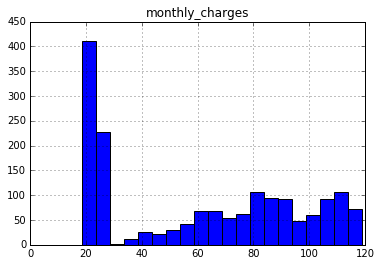

In [16]:
# Show the ditribution of monthly charges through a histogram
telco.hist(column = 'monthly_charges', bins=20)

In [17]:
# Create a new dataframe that contains tenure, monthly charges, and total charges, but not the customer id.
no_id_telco = telco.drop(columns='customer_id')
no_id_telco.head()


,tenure,monthly_charges,total_charges
0,71,109.70,7904.25
1,63,84.65,5377.80
2,65,90.45,5957.90
3,54,45.20,2460.55
4,72,116.80,8456.75


Text(0.5, 1.0, 'Total_charges')

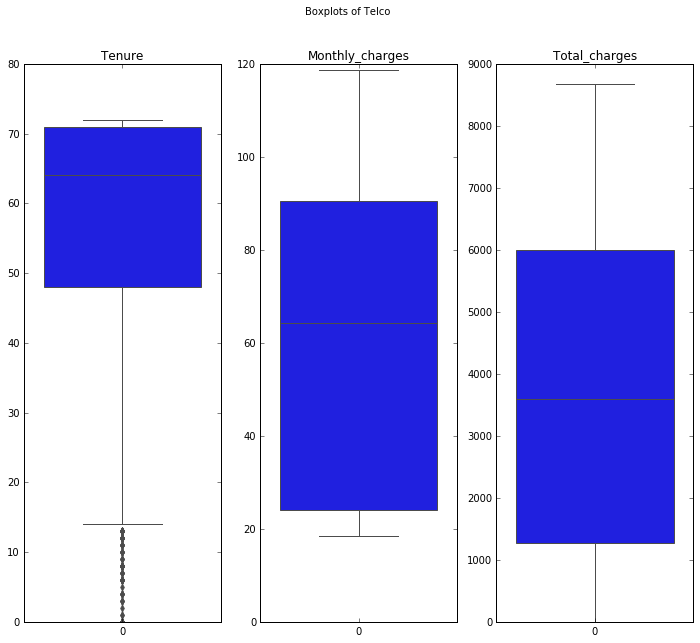

In [18]:
# Create a box plot of each variable in your new dataframe. This should be a single chart with 3 categorical plots,
# 1 each for tenure, monthly charges, total charges.
plt.figure(figsize=(12,10))
plt.suptitle('Boxplots of Telco')

plt.subplot(131)
sns.boxplot(data=telco['tenure'])
plt.title('Tenure')

plt.subplot(132)
sns.boxplot(data=telco['monthly_charges'])
plt.title('Monthly_charges')

plt.subplot(133)
sns.boxplot(data=telco['total_charges'])
plt.title('Total_charges')

In [19]:
telco.head()

,customer_id,tenure,monthly_charges,total_charges
0,0013-SMEOE,71,109.70,7904.25
1,0014-BMAQU,63,84.65,5377.80
2,0016-QLJIS,65,90.45,5957.90
3,0017-DINOC,54,45.20,2460.55
4,0017-IUDMW,72,116.80,8456.75


In [20]:
# Split your data into a test and train dataset. Set the random_state to 123. You should end up with 4 dataframes: 
# X_train, X_test, y_train, y_test.
X = telco.drop(['customer_id', 'total_charges'], axis=1)
y = telco[['total_charges']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

In [21]:
train = pd.concat([X_train, y_train], axis=1)
print("Train columns:  %s" % list(train.columns))
print("Train dimensions (rows, columns):", train.shape)

Train columns:  ['tenure', 'monthly_charges', 'total_charges']
Train dimensions (rows, columns): (1356, 3)


In [22]:
test = pd.concat([X_test, y_test], axis=1)
print("Test columns:  %s" % list(test.columns))
print("Test dimensions (rows, columns):", test.shape)

Test columns:  ['tenure', 'monthly_charges', 'total_charges']
Test dimensions (rows, columns): (339, 3)


In [23]:
X_train.head()

,tenure,monthly_charges
909,66,85.90
550,71,105.55
1173,60,110.60
5,72,101.30
1536,72,110.15


In [24]:
if X_train.shape[0] == y_train.shape[0]:
    print("X & y train rows ARE equal")
else:
    print("X & y train rows ARE NOT equal")


if X_test.shape[0] == y_test.shape[0]:
    print("X & y test rows ARE equal")
else:
    print("X & y test rows ARE NOT equal")

if train.shape[1] == test.shape[1]:
    print("Number of columns in train & test ARE equal")
else:
    print("Number of columns in train & test ARE NOT equal")

train_split = train.shape[0] / (train.shape[0] + test.shape[0])
test_split = test.shape[0] / (train.shape[0] + test.shape[0])

print("Train Split: %.2f" % train_split)
print("Test Split: %.2f" % test_split)

X & y train rows ARE equal
X & y test rows ARE equal
Number of columns in train & test ARE equal
Train Split: 0.80
Test Split: 0.20


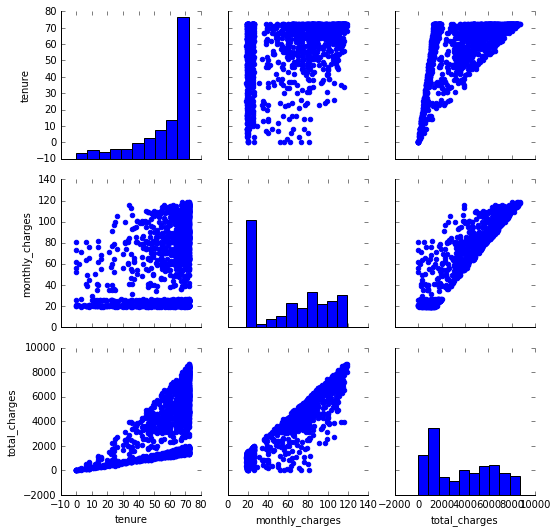

In [25]:
# Using the in-sample data (X_train and y_train)
# Create a scatterplot for each combination of variables.

g = sns.PairGrid(train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);

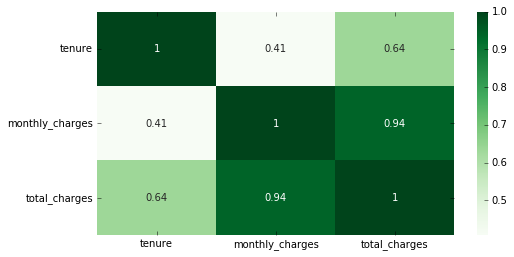

In [26]:
# Create a heatmap containing the 3 variables.
plt.figure(figsize=(8,4))
sns.heatmap(train.corr(), cmap='Greens', annot=True)

In [27]:
# Compute pearson's correlation coefficient and print it's value in the sentence "Pearson's R is ____ with a 
# significance p-value of ____"
[[column, pearsonr(X_train[column], y_train.total_charges)] for column in X_train]
# print('Pearson\'s R is {:.2%} with a significance p_value of {:.2%.'.format(pearsonr(X_train[column]), pearsonr(y_train.total_charges)))


[['tenure', (0.6350021065102249, 5.692136817600413e-154)],
 ['monthly_charges', (0.9417149491320433, 0.0)]]

In [28]:
# Train (aka fit) a linear regression model, modeling total charges as a linear function of tenure.
lm1 = LinearRegression(fit_intercept=False)

In [29]:
lm1.fit(X_train[['tenure']], y_train)
print(lm1)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)


In [30]:
# What is the y-intercept of the regression line? Translate the intercept in plain english, i.e. what is means in 
# the context of the data.
lm1_y_intercept = lm1.intercept_
print(lm1_y_intercept)
# The y_intercept is 0 as we are making our model work on the basis that a customer's total charges for their first month is $0.

0.0


In [31]:
# What the slope of the regression line? Translate the slope in plain english, i.e. what is means in the context of the data.
lm1_coefficients = lm1.coef_
print(lm1_coefficients)
# The slope of the line is 67.81 which is saying that our model says that for each month of tenure, the customer's estimated charge increase $67.81.

[[67.81557644]]


In [32]:
# Write the linear function in the form of y = mx + b using the parameters that were estimated from the algorithm 
# and the variable names for y and x specific to your data.
total_charges = 67.81*tenure

NameError: name 'tenure' is not defined

In [33]:
# Test your model on the training sample. That is, use your newly fit model to predict the total charges using tenure.
lm1_pred = lm1.predict(X_train[['tenure']])

In [34]:
mse_lm1_pred = mean_squared_error(y_train, lm1_pred)
print('lm1_pred\n mse:{:.3}'.format(mse_lm1_pred))
r2_lm1_pred = r2_score(y_train, lm1_pred)
print('  {:.2%} of the variance in the customer\'s total_charges can be explained by tenure.'.format(r2_lm1_pred))
mae_lm1_pred = median_absolute_error(y_train, lm1_pred)
print(' mae:{:.3}'.format(mae_lm1_pred))

lm1_pred
 mse:4.21e+06
  37.46% of the variance in the customer's total_charges can be explained by tenure.
 mae:1.73e+03


In [35]:
# Using the out-of-sample data (X_test, y_test)
# Test your model on the test sample.
test_lm1_pred = lm1.predict(X_test[['tenure']])

In [36]:
mse_test_lm1_pred = mean_squared_error(y_test, test_lm1_pred)
print('test_lm1_pred\n mse:{:.3}'.format(mse_test_lm1_pred))
r2_test_lm1_pred = r2_score(y_test, test_lm1_pred)
print('  {:.2%} of the variance in the customer\'s total_charges can be explained by tenure.'.format(r2_test_lm1_pred))
mae_test_lm1_pred = median_absolute_error(y_test, test_lm1_pred)
print(' mae:{:.3}'.format(mae_test_lm1_pred))


test_lm1_pred
 mse:3.88e+06
  38.34% of the variance in the customer's total_charges can be explained by tenure.
 mae:1.59e+03


In [37]:
# Calculate the p-value of the regressor for the train and test sample. Hint: f_regression
# sklearn.feature_selection.f_regression(X, y, center=True)
from sklearn.feature_selection import f_regression

In [38]:
f_regression(X_test[['tenure']], y_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([231.6718391]), array([3.48651193e-40]))

Text(0.5, 1.0, 'Predicted vs Actual Total Charges')

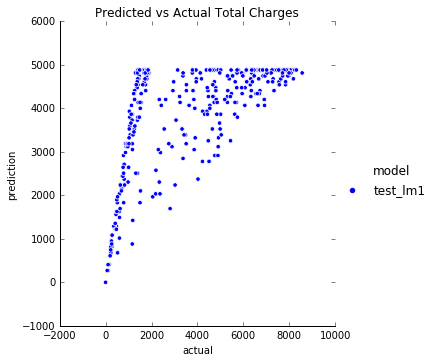

In [39]:
# # Create a scatter plot of the predicted values versus the actual values in the test sample.

pd.DataFrame({'actual' : y_test.total_charges,
              'test_lm1' : test_lm1_pred.ravel()})\
    .melt(id_vars=['actual'], var_name='model', value_name='prediction')\
    .pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')
plt.plot
plt.title('Predicted vs Actual Total Charges')

In [40]:
from numpy.polynomial.polynomial import polyfit

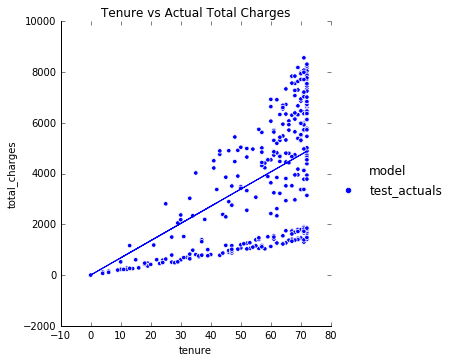

In [41]:
# Create a scatter plot of the actual values of x and y in the test sample with the regression line layered over.
pd.DataFrame({'tenure' : X_test.tenure,
              'test_actuals' : y_test.total_charges})\
    .melt(id_vars=['tenure'], var_name='model', value_name='total_charges')\
    .pipe((sns.relplot, 'data'), x='tenure', y='total_charges', hue='model')
plt.plot
plt.title('Tenure vs Actual Total Charges')
x = X_test.tenure
y = y_test.total_charges
m = 67.8155
b = 0
plt.plot(x, b + m * x, '-')
plt.show()

Text(0, 0.5, 'Residuals')

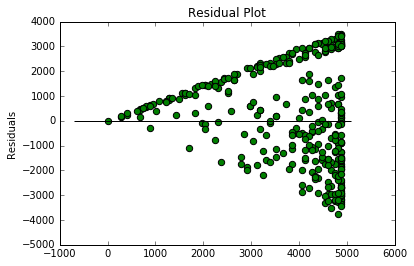

In [42]:
# Create a scatter plot of the residuals (x axis: predicted values of final grade, y axis: the residual values 
# (remember definition of residual from previous lesson). Layer over it a horizonal line that represents no residual.
plt.scatter(test_lm1_pred, test_lm1_pred - y_test, c='g', s=40)
plt.hlines(y=0, xmin=-700, xmax=5100)
plt.title('Residual Plot')
plt.ylabel('Residuals')